# Molecular Simulation with OpenMM

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bacalhau-project/examples/blob/main/molecular-dynamics/openmm/index.ipynb)
[![Open In Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/bacalhau-project/examples/HEAD?labpath=molecular-dynamics/openmm/index.ipynb)

[OpenMM](https://github.com/openmm/openmm) is a toolkit for molecular simulation. Physic based libraries like OpenMM are then useful for refining the structure and exploring functional interactions with other molecules. It provides a combination of extreme flexibility (through custom forces and integrators), openness, and high performance (especially on recent GPUs) that make it truly unique among simulation codes.

References:

* https://github.com/openmm/openmm
* https://github.com/Openzyme/openzyme (Docker scaffolding to run OpenMM)


### Goal

The goal of this notebook is to showcase how to containerize an OpenMM workload so that it can be executed on the Bacalhau network and to take advantage of the distributed storage & compute resources.

### Prerequisites

This example requires Docker. If you don't have Docker installed, you can install it from [here](https://docs.docker.com/install/). Docker commands will not work on hosted notebooks like Google Colab, but the Bacalhau commands will.

Make sure you have the latest `bacalhau` client installed by following the [getting started instructions](../../../getting-started/installation)

## Protein data

We use a processed 2DRI dataset that represents the ribose binding protein in bacterial transport and chemotaxis. The source organism is the known [Escherichia coli](https://en.wikipedia.org/wiki/Escherichia_coli) bacteria.
You can find details on this data at the related [RCSB Protein Data Bank page](https://www.rcsb.org/structure/2dri).

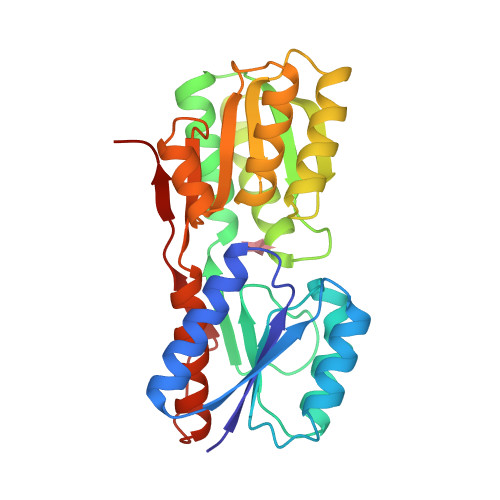

Protein data can be stored in a `.pdb` file, this is a human readable format.
It provides for description and annotation of protein and nucleic acid structures including atomic coordinates, secondary structure assignments, as well as atomic connectivity.
Please find more info about PDB format in [this article](https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html).

Let us sneak peak into the dataset by printing the head of the file.
Among other thigns, we can see it contains a number of ATOM records. These describe the coordinates of the atoms that are part of the protein.

In [1]:
%%bash
head ./dataset/2dri-processed.pdb

REMARK   1 CREATED WITH OPENMM 7.6, 2022-07-12
CRYST1   81.309   81.309   81.309  90.00  90.00  90.00 P 1           1 
ATOM      1  N   LYS A   1      64.731   9.461  59.430  1.00  0.00           N  
ATOM      2  CA  LYS A   1      63.588  10.286  58.927  1.00  0.00           C  
ATOM      3  HA  LYS A   1      62.707   9.486  59.038  1.00  0.00           H  
ATOM      4  C   LYS A   1      63.790  10.671  57.468  1.00  0.00           C  
ATOM      5  O   LYS A   1      64.887  11.089  57.078  1.00  0.00           O  
ATOM      6  CB  LYS A   1      63.458  11.567  59.749  1.00  0.00           C  
ATOM      7  HB2 LYS A   1      63.333  12.366  58.879  1.00  0.00           H  
ATOM      8  HB3 LYS A   1      64.435  11.867  60.372  1.00  0.00           H  


## Prepare & Run the task


1. Upload the data to IPFS
1. Create a docker image with the code and dependencies
1. Run the docker image on the Bacalhau network using the IPFS data


### Upload the Data to IPFS

The first step is to upload the data to IPFS. The simplest way to do this is to use a third party service to "pin" data to the IPFS network, to ensure that the data exists and is available. To do this you need an account with a pinning service like [web3.storage](https://web3.storage/) or [Pinata](https://pinata.cloud/). Once registered you can use their UI or API or SDKs to upload files.

For the purposes of this example I pinned the `2dri-processed.pdb` file to IPFS via [web3.storage](https://web3.storage/).

This resulted in the IPFS CID of `bafybeig63whfqyuvwqqrp5456fl4anceju24ttyycexef3k5eurg5uvrq4`.

<!-- TODO: Add link to notebook showing people how to upload data to IPFS -->

### Create a Docker Image to Process the Data

Next we will create the docker image that will process the data. The docker image will contain the code and dependencies needed to perform the conversion. This code originated [wesfloyd](https://github.com/wesfloyd/openmm-test). Thank you! 🤗

:::tip
For more information about working with custom containers, see the [custom containers example](../../workload-onboarding/custom-containers/).
:::

The key thing to watch out for here is the paths to the data. I'm using the default bacalhau output directory `/outputs` to write my data to. And the input data is mounted to the `/inputs` directory. But as you will see in a moment, web3.storage has added another `input` directory that we need to account for.

In [8]:
%%writefile run_openmm_simulation.py
import os
from openmm import *
from openmm.app import *
from openmm.unit import *

# Input Files
input_path = '/inputs/2dri-processed.pdb'
os.path.exists(input_path) # check if input file exists
pdb = PDBFile(input_path)
forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')

# Output
output_path = '/outputs/final_state.pdbx'
if not os.path.exists(os.path.dirname(output_path)): # check if ouput dir exists
    os.makedirs(os.path.dirname(output_path))

# System Configuration

nonbondedMethod = PME
nonbondedCutoff = 1.0*nanometers
ewaldErrorTolerance = 0.0005
constraints = HBonds
rigidWater = True
constraintTolerance = 0.000001
hydrogenMass = 1.5*amu

# Integration Options

dt = 0.002*picoseconds
temperature = 310*kelvin
friction = 1.0/picosecond
pressure = 1.0*atmospheres
barostatInterval = 25

# Simulation Options

steps = 10
equilibrationSteps = 0
#platform = Platform.getPlatformByName('CUDA')
platform = Platform.getPlatformByName('CPU')
#platformProperties = {'Precision': 'single'}
platformProperties = {}
dcdReporter = DCDReporter('trajectory.dcd', 1000)
dataReporter = StateDataReporter('log.txt', 1000, totalSteps=steps,
    step=True, time=True, speed=True, progress=True, elapsedTime=True, remainingTime=True, potentialEnergy=True, kineticEnergy=True, totalEnergy=True, temperature=True, volume=True, density=True, separator='\t')
checkpointReporter = CheckpointReporter('checkpoint.chk', 1000)

# Prepare the Simulation

print('Building system...')
topology = pdb.topology
positions = pdb.positions
system = forcefield.createSystem(topology, nonbondedMethod=nonbondedMethod, nonbondedCutoff=nonbondedCutoff,
    constraints=constraints, rigidWater=rigidWater, ewaldErrorTolerance=ewaldErrorTolerance, hydrogenMass=hydrogenMass)
system.addForce(MonteCarloBarostat(pressure, temperature, barostatInterval))
integrator = LangevinMiddleIntegrator(temperature, friction, dt)
integrator.setConstraintTolerance(constraintTolerance)
simulation = Simulation(topology, system, integrator, platform, platformProperties)
simulation.context.setPositions(positions)

# Minimize and Equilibrate

print('Performing energy minimization...')
simulation.minimizeEnergy()
print('Equilibrating...')
simulation.context.setVelocitiesToTemperature(temperature)
simulation.step(equilibrationSteps)

# Simulate

print('Simulating...')
simulation.reporters.append(dcdReporter)
simulation.reporters.append(dataReporter)
simulation.reporters.append(checkpointReporter)
simulation.currentStep = 0
simulation.step(steps)

# Write file with final simulation state

state = simulation.context.getState(getPositions=True, enforcePeriodicBox=system.usesPeriodicBoundaryConditions())
with open(output_path, mode="w+") as file:
    PDBxFile.writeFile(simulation.topology, state.getPositions(), file)
print('Simulation complete, file written to disk at: {}'.format(output_path))

Overwriting run_openmm_simulation.py


In [12]:
%%writefile Dockerfile
FROM conda/miniconda3

RUN conda install -y -c conda-forge openmm

WORKDIR /project

COPY ./run_openmm_simulation.py /project

LABEL org.opencontainers.image.source https://github.com/bacalhau-project/examples

CMD ["python","run_openmm_simulation.py"]

Overwriting Dockerfile


In [4]:
%%bash
#docker buildx build --platform linux/amd64 --push -t ghcr.io/bacalhau-project/examples/openmm:0.3 .

### Test the Container Locally

Before we upload the container to the Bacalhau network, we should test it locally to make sure it works.

In [13]:
%%bash
docker run \
    -v $(pwd)/dataset:/inputs/ \
    -v $(pwd)/output:/output \
    ghcr.io/bacalhau-project/examples/openmm:0.3

Building system...
Performing energy minimization...
Equilibrating...
Simulating...
Simulation complete, file written to disk at: /outputs/final_state.pdbx


### Run a Bacalhau Job

Now that we have the data in IPFS and the docker image pushed, we can run a job on the Bacalhau network.

I find it useful to first run a simple test with a known working container to ensure the data is located in the place I expect, because some storage providers add their own opinions. E.g. web3.storage wraps the directory uploads in a top level directory.

In [15]:
%%bash
rm -rf stdout stderr volumes shards
bacalhau docker run \
        --download \
        --inputs bafybeig63whfqyuvwqqrp5456fl4anceju24ttyycexef3k5eurg5uvrq4 \
        ubuntu -- ls /inputs

423d220d-fef4-41ea-ae08-f6a9361bff38


14:22:16.554 | INF ipfs/downloader.go:115 > Found 1 result shards, downloading to temporary folder.
14:22:19.096 | INF ipfs/downloader.go:195 > Combining shard from output volume 'outputs' to final location: '/Users/enricorotundo/winderresearch/ProtocolLabs/examples/todo/openmm'



2dri-processed.pdb



In [16]:
%%bash
rm -rf stdout stderr volumes shards
bacalhau docker run \
    --inputs bafybeig63whfqyuvwqqrp5456fl4anceju24ttyycexef3k5eurg5uvrq4 \
    --download \
    ghcr.io/bacalhau-project/examples/openmm:0.3 -- ls -la /inputs/

44e995c7-d6fd-4e69-a461-e88e5f6dc01c


And finally let's run the full job. This time I will not download the data immediately, because the job takes a few minutes to complete. The commands are below, but you will need to wait until the job completes before they work.

In [17]:
%%bash --out job_id
bacalhau docker run \
    --inputs bafybeig63whfqyuvwqqrp5456fl4anceju24ttyycexef3k5eurg5uvrq4 \
    --wait \
    ghcr.io/bacalhau-project/examples/openmm:0.3 -- python run_openmm_simulation.py

In [18]:
%env JOB_ID={job_id}

env: JOB_ID=971da05e-6de0-42d7-a5b5-b91df199c548


In [19]:
%%bash
bacalhau list --id-filter=${JOB_ID} --no-style

 CREATED   ID        JOB                      STATE      VERIFIED  PUBLISHED               
 12:26:13  971da05e  Docker ghcr.io/bacal...  Completed            /ipfs/QmT1QECs5NsQLj... 


### Get Results

Now let's download and display the result from the results directory. We can use the `bacalhau get` command to download the results from the output data volume. The `--output-dir` argument specifies the directory to download the results to.

In [20]:
%%bash
rm -rf stdout stderr volumes shards
bacalhau get ${JOB_ID} # Download the results

14:30:50.098 | INF bacalhau/get.go:67 > Fetching results of job '971da05e-6de0-42d7-a5b5-b91df199c548'...
14:30:51.304 | INF ipfs/downloader.go:115 > Found 1 result shards, downloading to temporary folder.
14:30:56.784 | INF ipfs/downloader.go:195 > Combining shard from output volume 'outputs' to final location: '/Users/enricorotundo/winderresearch/ProtocolLabs/examples/todo/openmm'
